# Comparison Study of Outlier Detection
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연

**Linear**

|Method|Accuracy|Precision|Recall|F1 Score|
|:---:|:---:|:---:|:---:|:---:|
|Proposed Method|**0.992**|**0.992**|**1.000**|**0.996**|
|LOF (Breunig et al., 2000)|0.871|0.962|0.900|0.930|
|OCSVM (Sch¨olkopf et al., 2001)|0.940|0.994|0.942|0.968|
|ABOD (Kriegel et al., 2008)|0.988|0.994|0.994|0.994|
|Isolation Forest (Liu et al., 2008)|0.881|1.000|0.875|0.933|

**one dimensional manifold**

|Method|Accuracy|Precision|Recall|F1 Score|
|:---:|:---:|:---:|:---:|:---:|
|Proposed Method|**0.997**|**0.997**|**1.000**|**0.998**|
|LOF (Breunig et al., 2000)|0.886|0.987|0.892|0.937|
|OCSVM (Sch¨olkopf et al., 2001)|0.923|0.988|0.931|0.958|
|ABOD (Kriegel et al., 2008)|0.988|0.994|0.994|0.994|
|Isolation Forest (Liu et al., 2008)|0.477|0.989|0.455|0.623|

Bummy

|Method|Accuracy|Precision|Recall|F1 Score|
|:---:|:---:|:---:|:---:|:---:|
|Proposed Method|**0.991**|**0.993**|**0.997**|**0.995**|
|LOF (Breunig et al., 2000)|0.918|0.954|0.959|0.957|
|OCSVM (Sch¨olkopf et al., 2001)|0.865|0.955|0.901|0.927|
|ABOD (Kriegel et al., 2008)|0.905|0.951|0.949|0.950|
|Isolation Forest (Liu et al., 2008)|0.761|0.953|0.789|0.863|

Circle(n=5000, 음수쪽 3%. 양수쪽 2%)

|Method|Accuracy|Precision|Recall|F1 Score|
|:---:|:---:|:---:|:---:|:---:|
|Proposed Method|**0.972**|**0.989**|**0.982**|**0.985**|
|LOF (Breunig et al., 2000)|0.865|0.950|0.905|0.927|
|OCSVM (Sch¨olkopf et al., 2001)|0.921|0.985|0.932|0.957|
|ABOD (Kriegel et al., 2008)|0.970|0.984|$\underline{0.984}$|0.984|
|Isolation Forest (Liu et al., 2008)|0.855|$\underline{0.993}$|0.853|0.918|

**latex**

% Please add the following required packages to your document preamble:
% \usepackage[normalem]{ulem}
% \useunder{\uline}{\ul}{}
\begin{table}[]
\begin{tabular}{|lcccc}
\hline
\multicolumn{5}{|c|}{Linear}                                                                                                                                                             \\ \hline
\multicolumn{1}{|l|}{Method}                              & \multicolumn{1}{c|}{Accuracy} & \multicolumn{1}{c|}{Precision} & \multicolumn{1}{c|}{Recall} & \multicolumn{1}{c|}{F1 Score} \\ \hline
\multicolumn{1}{|l|}{Propose Method}                      & \textbf{0.939}                & {\ul \textbf{1.000}}           & \textbf{0.936}              & \textbf{0.967}                \\ \cline{1-1}
\multicolumn{1}{|l|}{LOF (Breunig et al., 2000)}          & 0.871                         & 0.962                          & 0.900                       & 0.930                         \\ \cline{1-1}
\multicolumn{1}{|l|}{OCSVM (Sch¨olkopf et al., 2001)}     & 0.940                         & 0.994                          & 0.942                       & 0.968                         \\ \cline{1-1}
\multicolumn{1}{|l|}{ABOD (Kriegel et al., 2008)}         & {\ul 0.988}                   & 0.994                          & {\ul 0.994}                 & {\ul 0.994}                   \\ \cline{1-1}
\multicolumn{1}{|l|}{Isolation Forest (Liu et al., 2008)} & 0.881                         & {\ul 1.000}                    & 0.875                       & 0.933                         \\ \hline
\multicolumn{5}{|c|}{One Dimensional Manifold}                                                                                                                                           \\ \hline
\multicolumn{1}{|l|}{Method}                              & \multicolumn{1}{c|}{Accuracy} & \multicolumn{1}{c|}{Precision} & \multicolumn{1}{c|}{Recall} & \multicolumn{1}{c|}{F1 Score} \\ \hline
\multicolumn{1}{|l|}{Propose Method}                      & \textbf{0.997}                & \textbf{0.997}                 & {\ul \textbf{1.000}}        & \textbf{0.998}                \\ \cline{1-1}
\multicolumn{1}{|l|}{LOF (Breunig et al., 2000)}          & 0.866                         & 0.987                          & 0.892                       & 0.937                         \\ \cline{1-1}
\multicolumn{1}{|l|}{OCSVM (Sch¨olkopf et al., 2001)}     & 0.923                         & 0.988                          & 0.931                       & 0.958                         \\ \cline{1-1}
\multicolumn{1}{|l|}{ABOD (Kriegel et al., 2008)}         & {\ul 0.988}                   & {\ul 0.994}                    & 0.994                       & {\ul 0.994}                   \\ \cline{1-1}
\multicolumn{1}{|l|}{Isolation Forest (Liu et al., 2008)} & 0.477                         & 0.989                          & 0.455                       & 0.623                         \\ \hline
\multicolumn{5}{|c|}{Two Dimensional Manifold}                                                                                                                                           \\ \hline
\multicolumn{1}{|l|}{Method}                              & \multicolumn{1}{c|}{Accuracy} & \multicolumn{1}{c|}{Precision} & \multicolumn{1}{c|}{Recall} & \multicolumn{1}{c|}{F1 Score} \\ \hline
\multicolumn{1}{|l|}{Propose Method}                      & {\ul \textbf{0.960}}          & {\ul \textbf{0.969}}           & {\ul \textbf{0.990}}        & {\ul \textbf{0.979}}          \\ \cline{1-1}
\multicolumn{1}{|l|}{LOF (Breunig et al., 2000)}          & 0.918                         & 0.954                          & 0.959                       & 0.957                         \\ \cline{1-1}
\multicolumn{1}{|l|}{OCSVM (Sch¨olkopf et al., 2001)}     & 0.865                         & 0.955                          & 0.901                       & 0.953                         \\ \cline{1-1}
\multicolumn{1}{|l|}{ABOD (Kriegel et al., 2008)}         & 0.905                         & 0.951                          & 0.949                       & 0.950                         \\ \cline{1-1}
\multicolumn{1}{|l|}{Isolation Forest (Liu et al., 2008)} & 0.761                         & 0.953                          & 0.789                       & 0.863                         \\ \cline{1-1}
\end{tabular}
\end{table}

ref: https://scikit-learn.org/stable/modules/outlier_detection.html

https://conferenceindex.org/conferences/applied-statistics

**Inliers are labeled 1, while outliers are labeled -1**

In [1237]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

from sklearn.datasets import fetch_kddcup99, fetch_covtype, fetch_openml
from sklearn.preprocessing import LabelBinarizer

import tqdm

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import plotly.graph_objects as go
from IPython.display import HTML

import plotly.express as px

from sklearn.covariance import EmpiricalCovariance, MinCovDet

from alibi_detect.od import IForest

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
import seaborn as sns

from PyNomaly import loop

from sklearn import svm

## EbayesThresh

In [1238]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


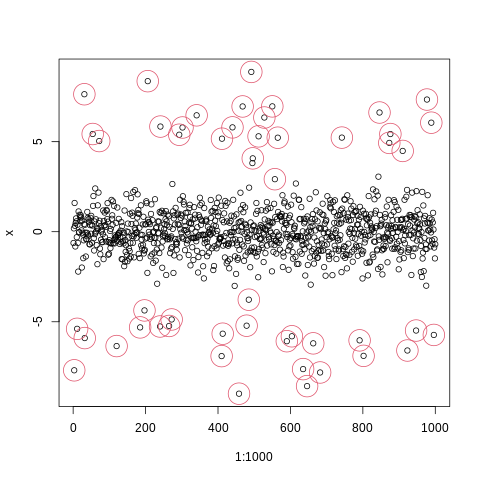

In [1239]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal = sample(c(runif(25,-7,-5), runif(25,5,7), rep(0,950)))
index_of_trueoutlier = which(signal!=0)
index_of_trueoutlier
x=signal+epsilon
plot(1:1000,x)
points(index_of_trueoutlier,x[index_of_trueoutlier],col=2,cex=4)

#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

In [1240]:
%R -o x
%R -o index_of_trueoutlier
%R -o signal

In [1241]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [1242]:
xhat = np.array(ebayesthresh(FloatVector(x)))

In [1243]:
# plt.plot(x)
# plt.plot(xhat)

In [1244]:
outlier_true_index = index_of_trueoutlier

In [1245]:
outlier_true_value = x[index_of_trueoutlier]

package와 비교를 위해 outlier는 -1, inlier는 1로 표시

In [1246]:
outlier_true_one = signal.copy()

In [1247]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

## sklearn.neighbors.LocalOutlierFactor

### 1. linear

In [1248]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [1249]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [1250]:
X = np.array(_df)

In [1251]:
clf = LocalOutlierFactor(n_neighbors=2)

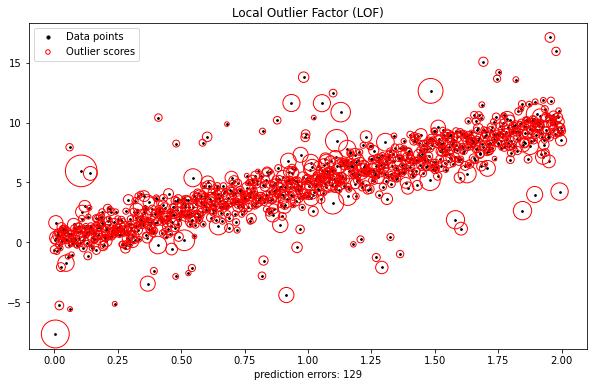

In [1252]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [1253]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [1254]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [1255]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [1256]:
w=np.zeros((1000,1000))

In [1257]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1258]:
_simul = SIMUL(_df)

In [1259]:
_simul.fit(sd=20)

In [1322]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>25').reset_index()['index'])

In [1323]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>25').reset_index()['y'])

In [1324]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [1325]:
outlier_simul_one = list(map(lambda x: -1 if x > 25 else 1,outlier_simul_one))

In [1326]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

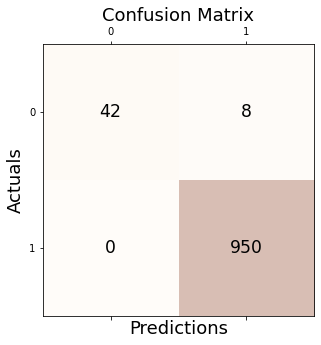

In [1327]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1328]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.992
Precision: 0.992
Recall: 1.000
F1 Score: 0.996


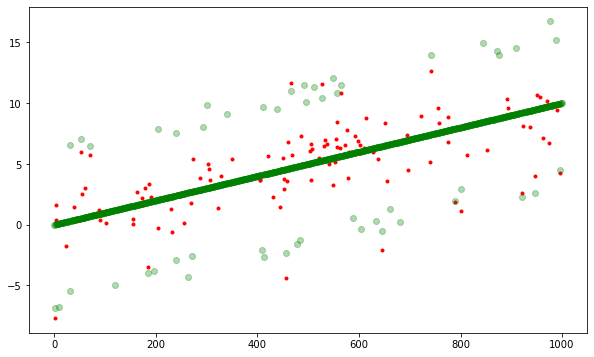

In [1329]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+signal,'go',alpha=0.3)

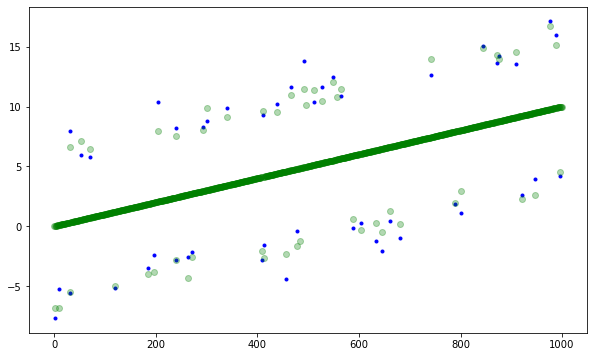

In [1268]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+signal,'go',alpha=0.3)

In [572]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

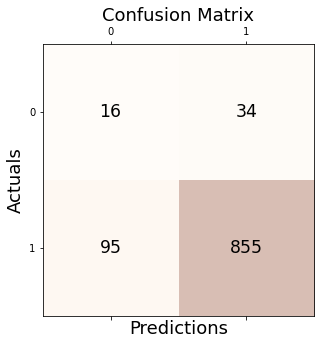

In [573]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [574]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.871
Precision: 0.962
Recall: 0.900
F1 Score: 0.930


### 2. linear(2)

In [39]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [40]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [41]:
X = np.array(_df)

In [42]:
clf = LocalOutlierFactor(n_neighbors=2)

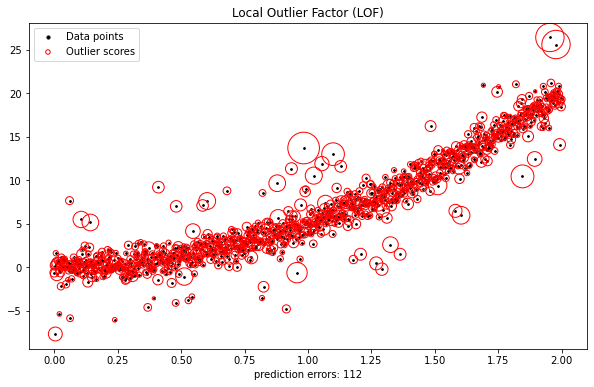

In [43]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [44]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [45]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [46]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [47]:
w=np.zeros((1000,1000))

In [48]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [49]:
_simul = SIMUL(_df)

In [50]:
_simul.fit()

In [51]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>4.5').reset_index()['index'])

In [52]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>4.5').reset_index()['y'])

In [53]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [54]:
outlier_simul_one = list(map(lambda x: -1 if x > 4.5 else 1,outlier_simul_one))

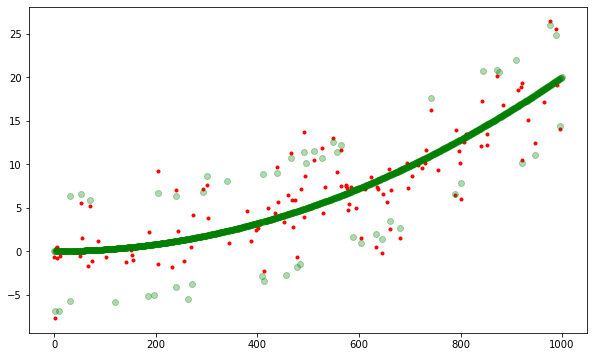

In [55]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+signal,'go',alpha=0.3)

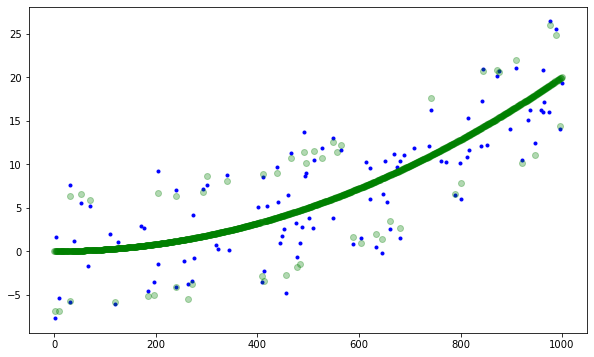

In [56]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+signal,'go',alpha=0.3)

In [57]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

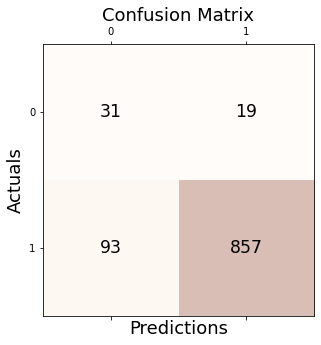

In [58]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [59]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.888
Precision: 0.978
Recall: 0.902
F1 Score: 0.939


In [60]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

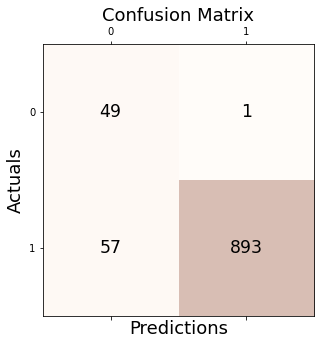

In [61]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [62]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.942
Precision: 0.999
Recall: 0.940
F1 Score: 0.969


### 3. sin

In [63]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [64]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [65]:
X = np.array(_df)

In [66]:
clf = LocalOutlierFactor(n_neighbors=2)

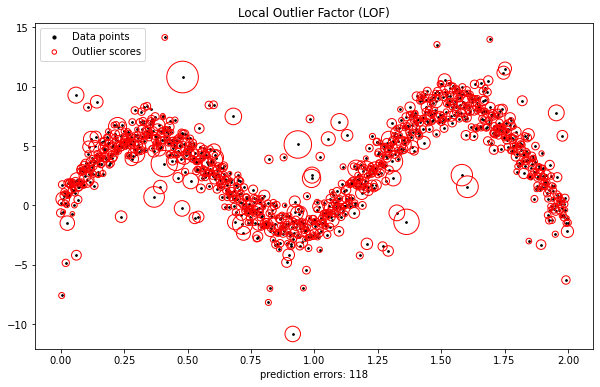

In [67]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [68]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [69]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [70]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [71]:
w=np.zeros((1000,1000))

In [72]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [73]:
_simul = SIMUL(_df)

In [74]:
_simul.fit()

In [75]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>4').reset_index()['index'])

In [76]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>4').reset_index()['y'])

In [77]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [78]:
outlier_simul_one = list(map(lambda x: -1 if x > 4 else 1,outlier_simul_one))

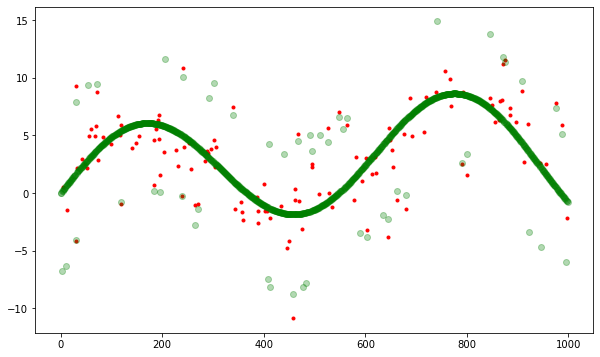

In [79]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+signal,'go',alpha=0.3)

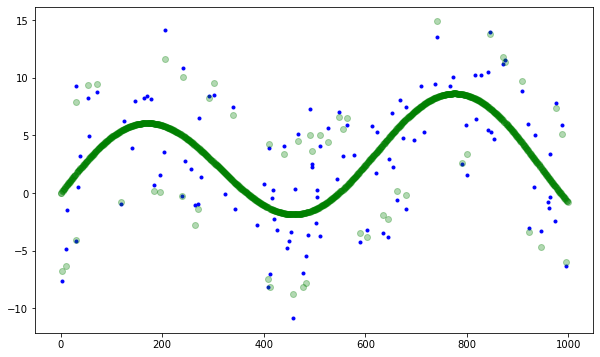

In [80]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+signal,'go',alpha=0.3)

In [81]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

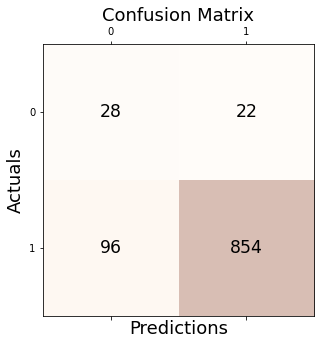

In [82]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [83]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.882
Precision: 0.975
Recall: 0.899
F1 Score: 0.935


In [84]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

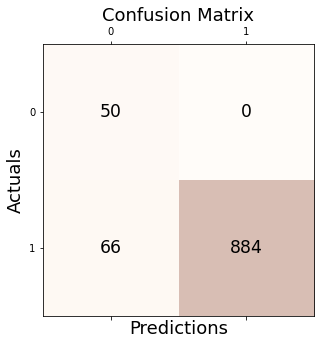

In [85]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [86]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.934
Precision: 1.000
Recall: 0.931
F1 Score: 0.964


### 4. cosin

In [87]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [88]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [89]:
X = np.array(_df)

In [90]:
clf = LocalOutlierFactor(n_neighbors=2)

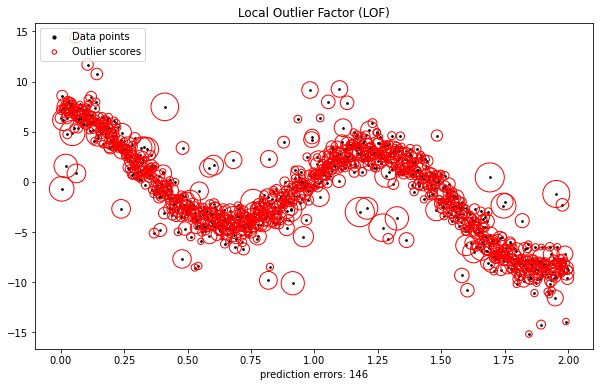

In [91]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

outlier

In [92]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [93]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [94]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [95]:
w=np.zeros((1000,1000))

In [96]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [97]:
_simul = SIMUL(_df)

In [98]:
_simul.fit()

In [99]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>4').reset_index()['index'])

In [100]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>4').reset_index()['y'])

In [101]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [102]:
outlier_simul_one = list(map(lambda x: -1 if x > 4 else 1,outlier_simul_one))

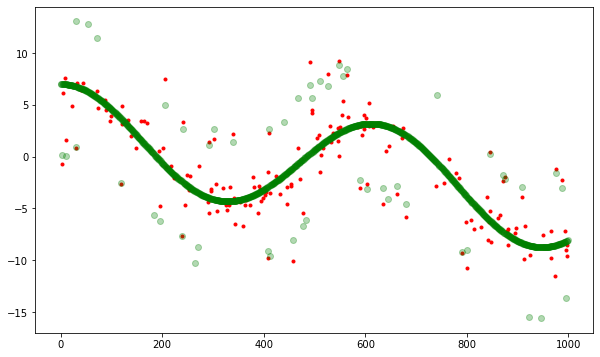

In [103]:
plt.figure(figsize=(10,6))
plt.plot(_df.loc[outlier_first_index].reset_index()['index'],_df.loc[outlier_first_index].reset_index()['y'],'r.')
plt.plot(_y1+signal,'go',alpha=0.3)

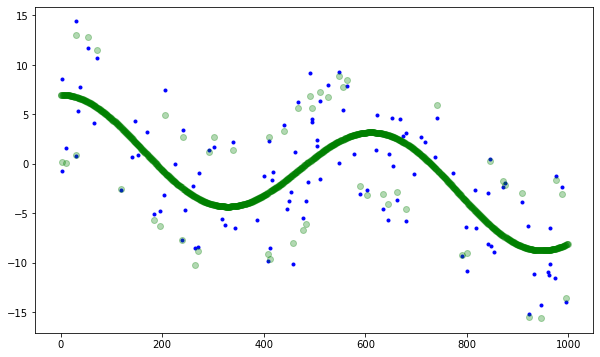

In [104]:
plt.figure(figsize=(10,6))
plt.plot(outlier_simul_first_index,outlier_simul_first_value,'b.')
plt.plot(_y1+signal,'go',alpha=0.3)

In [105]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

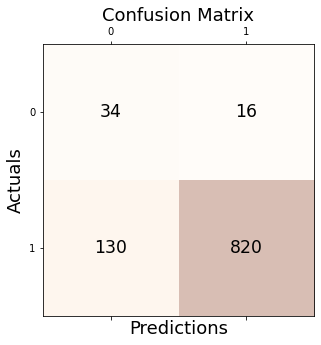

In [106]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [107]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.854
Precision: 0.981
Recall: 0.863
F1 Score: 0.918


In [108]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

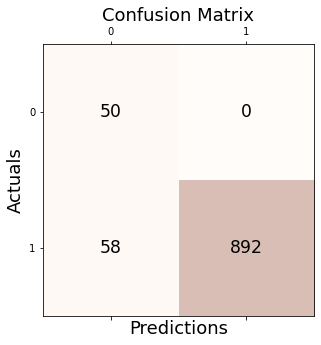

In [109]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [110]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.942
Precision: 1.000
Recall: 0.939
F1 Score: 0.969


### 5. One dimensional manifold

In [1185]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + x

In [1186]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [1187]:
X = np.array(_df)

In [1188]:
clf = LocalOutlierFactor(n_neighbors=2)

<Figure size 720x432 with 0 Axes>

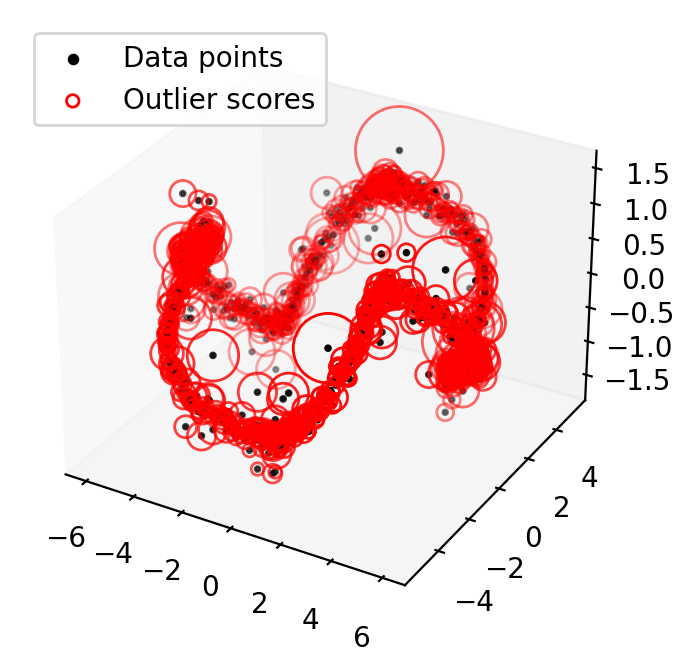

In [1189]:
ground_truth=outlier_true_one
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
plt.figure(figsize=(10,6))
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
# ax.title("Local Outlier Factor (LOF)")
ax.scatter3D(X[:, 0], X[:, 1],X[:, 2], color="k", s=3.0, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
ax.scatter3D(
    X[:, 0],
    X[:, 1],
    X[:, 2],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
ax.axis("tight")
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# ax.xlabel("prediction errors: %d" % (n_errors))
legend = ax.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
# ax.show()

outlier

In [1190]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [1191]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [1192]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=20): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [1193]:
_simul = SIMUL(_df)

In [1194]:
_simul.get_distance()

100%|██████████| 1000/1000 [00:02<00:00, 436.00it/s]


In [1195]:
_simul.get_weightmatrix(theta=(_simul.D[_simul.D>0].mean()),kappa=2500) 

In [1196]:
_simul.fit(sd=15,ref=20)

In [1197]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>20').reset_index()['index'])

In [1198]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>20').reset_index()['y'])

In [1199]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [1200]:
outlier_simul_one = list(map(lambda x: -1 if x > 20 else 1,outlier_simul_one))

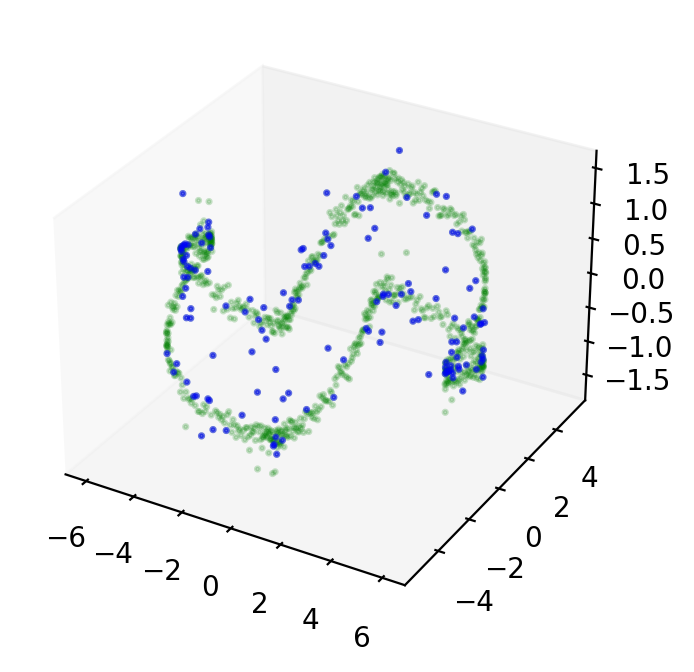

In [1201]:
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
top = f
bottom = np.zeros_like(top)
width=depth=0.05
ax.scatter3D(vx,vy,f,zdir='z',s=10,marker='.',c='green',alpha=0.2)
ax.scatter3D(_df.loc[outlier_first_index]['x'],_df.loc[outlier_first_index]['y'],_df.loc[outlier_first_index]['f'], zdir='z',s=10,marker='.',c='blue',alpha=0.5)
# ax.bar3d(vx, vy, bottom, width, depth, 0, color='Black',shade=False)

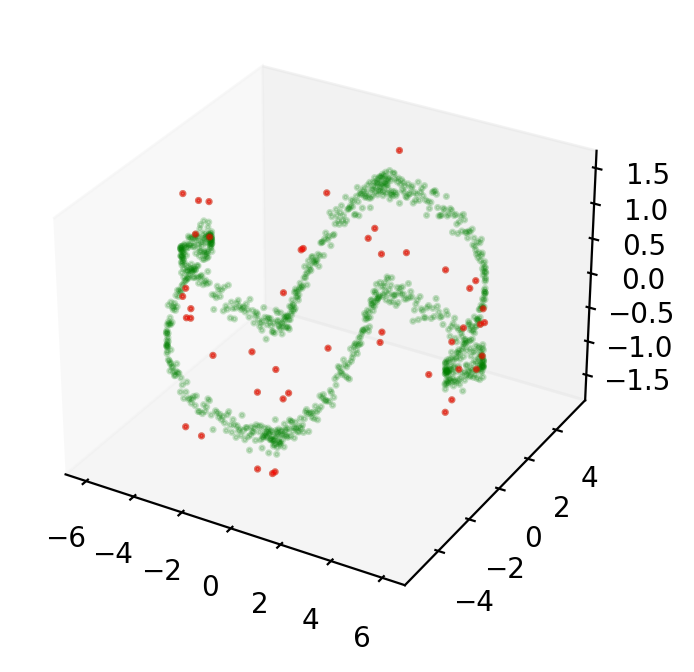

In [1202]:
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
top = f
bottom = np.zeros_like(top)
width=depth=0.05
ax.scatter3D(vx,vy,f,zdir='z',s=10,marker='.',c='green',alpha=0.2)
ax.scatter3D(_simul.df.loc[outlier_simul_first_index]['x'],_simul.df.loc[outlier_simul_first_index]['y'],_simul.df.loc[outlier_simul_first_index]['f'], zdir='z',s=10,marker='.',c='red',alpha=0.5)
# ax.bar3d(vx, vy, bottom, width, depth, 0, color='Black',shade=False)

In [1203]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

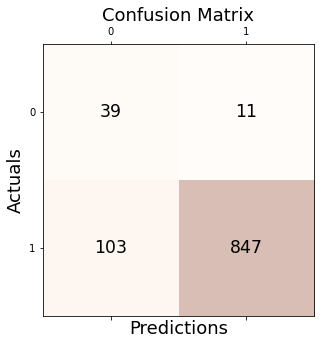

In [1204]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1205]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.886
Precision: 0.987
Recall: 0.892
F1 Score: 0.937


In [1206]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

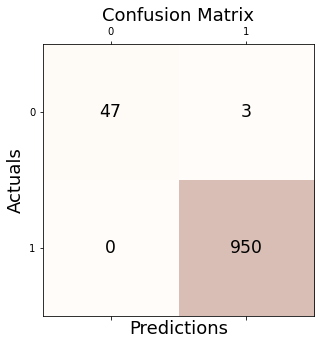

In [1207]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1208]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.997
Precision: 0.997
Recall: 1.000
F1 Score: 0.998


### 6. Bunny(Two dimensional manifold)

In [1209]:
G = graphs.Bunny()
n = G.N

In [1210]:
g = filters.Heat(G, tau=75) 

In [1211]:
normal = np.random.randn(n)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif
index_of_trueoutlier2 = np.where(unif!=0)

In [1212]:
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

2022-11-10 21:13:20,395:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [1213]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = -G.coords[:,2]

In [1214]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'fnoise':f+noise,'f' : f, 'noise': noise})

In [1215]:
outlier_true_index_2 = np.where(unif!=0)

In [1216]:
outlier_true_value_2 = unif[unif!=0]

In [1217]:
outlier_true_one_2 = unif.copy()

In [1218]:
outlier_true_one_2 = list(map(lambda x: -1 if x !=0  else 1,outlier_true_one_2))

In [1219]:
X = np.array(_df)

In [1220]:
clf = LocalOutlierFactor(n_neighbors=2)

In [1221]:
clf.fit_predict(X[:,:4])

array([1, 1, 1, ..., 1, 1, 1])

outlier

In [1222]:
outlier_first_index = np.where(clf.fit_predict(X[:,:4])==-1)

In [1223]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X[:,:4])==-1]

In [1224]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = _W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=6): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05

In [1225]:
_simul = SIMUL(_df)

In [1226]:
_simul.fit(sd=20,ref=10)

In [1227]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>10').reset_index()['index'])

In [1228]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>10').reset_index()['y'])

In [1229]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [1230]:
outlier_simul_one = list(map(lambda x: -1 if x > 10 else 1,outlier_simul_one))

In [1231]:
conf_matrix = confusion_matrix(outlier_true_one_2, clf.fit_predict(X[:,:4]))

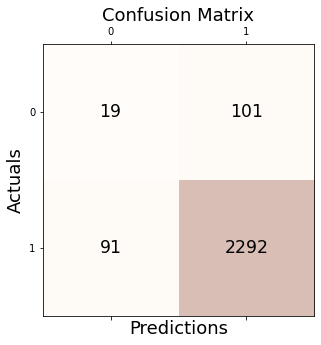

In [1232]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1233]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('Precision: %.3f' % precision_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('Recall: %.3f' % recall_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, clf.fit_predict(X[:,:4])))

Accuracy: 0.923
Precision: 0.958
Recall: 0.962
F1 Score: 0.960


In [1234]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_simul_one)

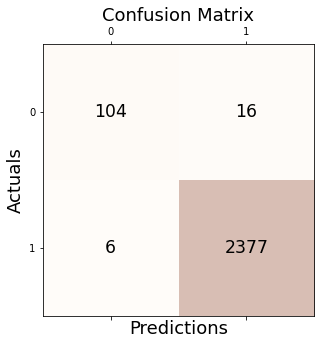

In [1235]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1236]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_simul_one))

Accuracy: 0.991
Precision: 0.993
Recall: 0.997
F1 Score: 0.995


---

## ABOD Angle Based Outlier Detection

contamination =0.05
- 5%의 이상치 감지

### 1.

In [165]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [166]:
_df=pd.DataFrame({'x':_x, 'y':_y})

ABOD(Angle Based Techniques Outlier Detection)

In [167]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [168]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

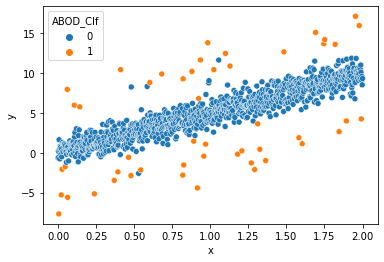

In [169]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

In [170]:
outlier_ABOD_one = list(abod_clf.labels_)

In [171]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [172]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

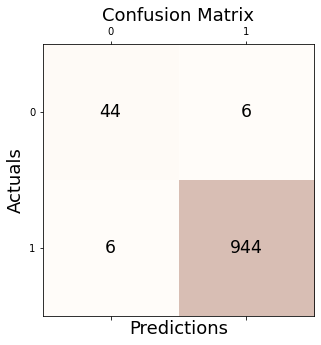

In [173]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [175]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.988
Precision: 0.994
Recall: 0.994
F1 Score: 0.994


### 2.

In [176]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [177]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [178]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [179]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

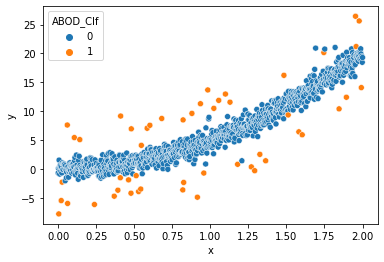

In [180]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

In [181]:
outlier_ABOD_one = list(abod_clf.labels_)

In [182]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [183]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

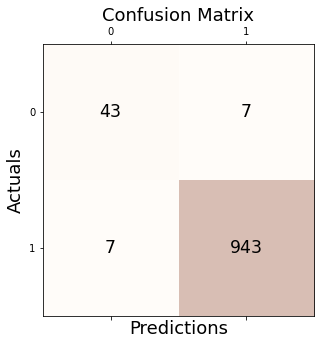

In [184]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [185]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.986
Precision: 0.993
Recall: 0.993
F1 Score: 0.993


### 3.

In [186]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [187]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [188]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [189]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

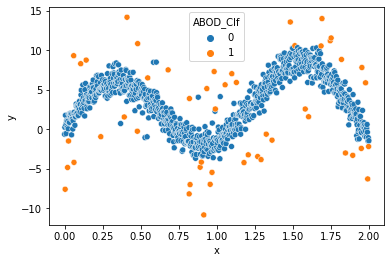

In [190]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

In [191]:
outlier_ABOD_one = list(abod_clf.labels_)

In [192]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [193]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

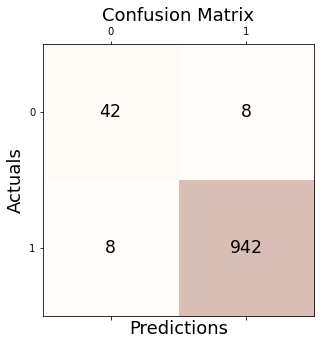

In [194]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [195]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.984
Precision: 0.992
Recall: 0.992
F1 Score: 0.992


### 4. 

In [196]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [197]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [198]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [199]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

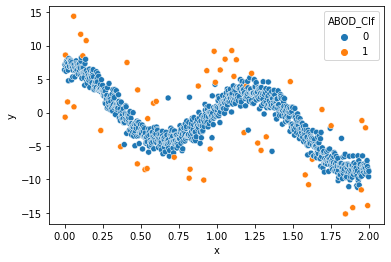

In [200]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

In [201]:
outlier_ABOD_one = list(abod_clf.labels_)

In [202]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [203]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

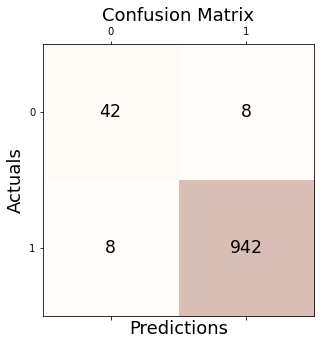

In [204]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [205]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.984
Precision: 0.992
Recall: 0.992
F1 Score: 0.992


### 5.

In [609]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + x

In [610]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [611]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y','f']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [612]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y', 'f']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

In [613]:
outlier_ABOD_one = list(abod_clf.labels_)

In [614]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [615]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

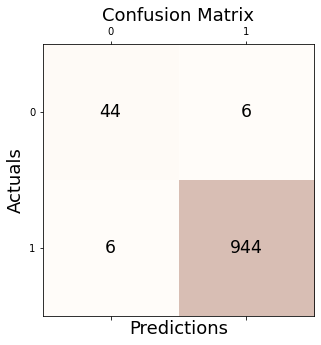

In [616]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [617]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.988
Precision: 0.994
Recall: 0.994
F1 Score: 0.994


### 6.

In [995]:
G = graphs.Bunny()
n = G.N

In [996]:
g = filters.Heat(G, tau=75) 

In [997]:
normal = np.random.randn(n)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif
index_of_trueoutlier2 = np.where(unif!=0)

In [998]:
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

2022-11-10 06:59:54,683:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [999]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = -G.coords[:,2]

In [1000]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'fnoise':f+noise,'f' : f, 'noise': noise})

In [1001]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y', 'z','fnoise']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [1002]:
cblof_clf = CBLOF(contamination=0.05,check_estimator=False, random_state=77)
cblof_clf.fit(_df[['x', 'y','z','fnoise']])
_df['ABOD_Clf'] = abod_clf.labels_
_df['CBLOF_Clf'] = cblof_clf.labels_

In [1003]:
outlier_ABOD_one = list(abod_clf.labels_)

In [1004]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [1005]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_ABOD_one)

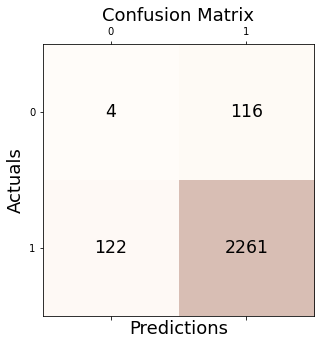

In [1006]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1007]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_ABOD_one))

Accuracy: 0.905
Precision: 0.951
Recall: 0.949
F1 Score: 0.950


---

##  Isolation Forest

### 1.

In [228]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [229]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [230]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [231]:
od.fit(_df[['x', 'y']])

In [232]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

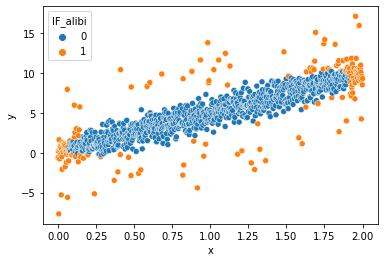

In [233]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [234]:
outlier_alibi_one = _df['IF_alibi']

In [235]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [236]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

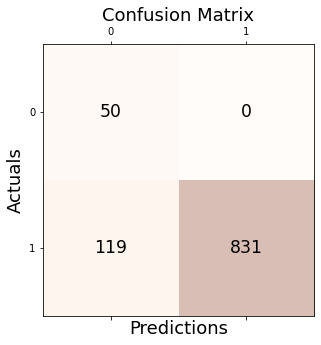

In [237]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [238]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.881
Precision: 1.000
Recall: 0.875
F1 Score: 0.933


### 2.

In [239]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [240]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [241]:
od.fit(_df[['x', 'y']])

In [242]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

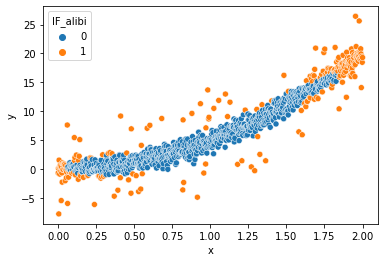

In [243]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [244]:
outlier_alibi_one = _df['IF_alibi']

In [245]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [246]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

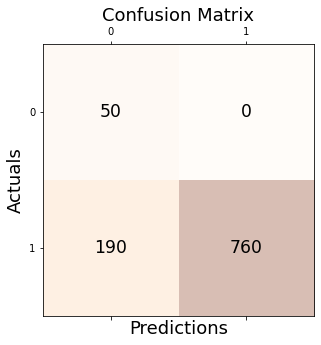

In [247]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [248]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.810
Precision: 1.000
Recall: 0.800
F1 Score: 0.889


### 3.

In [249]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [250]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [251]:
od.fit(_df[['x', 'y']])

In [252]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

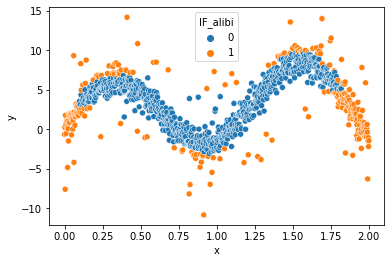

In [253]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [254]:
outlier_alibi_one = _df['IF_alibi']

In [255]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [256]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

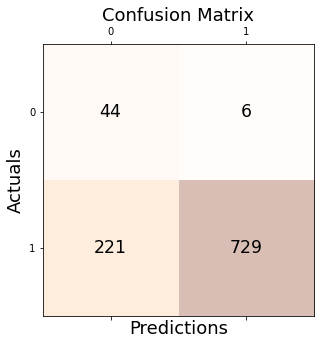

In [257]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [258]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.773
Precision: 0.992
Recall: 0.767
F1 Score: 0.865


### 4. 

In [259]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [260]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [261]:
od.fit(_df[['x', 'y']])

In [262]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

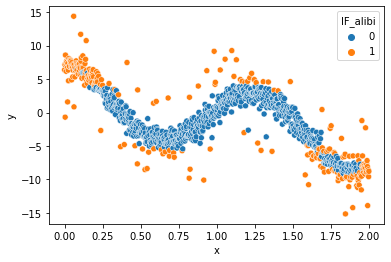

In [263]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [264]:
outlier_alibi_one = _df['IF_alibi']

In [265]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [266]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

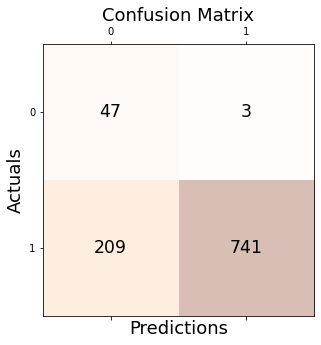

In [267]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [268]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.788
Precision: 0.996
Recall: 0.780
F1 Score: 0.875


### 5.

In [618]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + x

In [619]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [620]:
od.fit(_df[['x', 'y','f']])

In [621]:
preds = od.predict(
    _df[['x', 'y','f']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

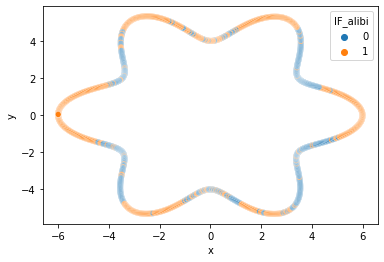

In [622]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [623]:
outlier_alibi_one = _df['IF_alibi']

In [624]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [625]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

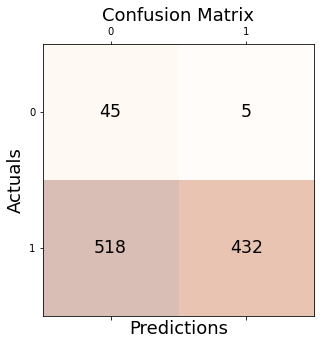

In [626]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [627]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.477
Precision: 0.989
Recall: 0.455
F1 Score: 0.623


### 6.

In [736]:
G = graphs.Bunny()
n = G.N

In [737]:
g = filters.Heat(G, tau=75) 

In [738]:
normal = np.random.randn(n)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif
index_of_trueoutlier2 = np.where(unif!=0)

In [739]:
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

2022-11-10 00:48:04,538:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [740]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = -G.coords[:,2]

In [741]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'fnoise':f+noise,'f' : f, 'noise': noise})

In [744]:
od.fit(_df[['x', 'y','z','fnoise']])

In [745]:
preds = od.predict(
    _df[['x', 'y','z','fnoise']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

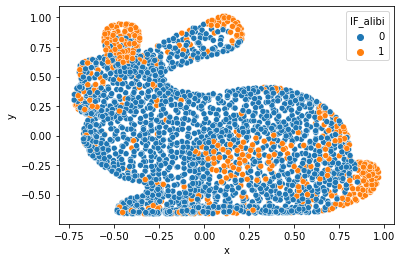

In [746]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [747]:
outlier_alibi_one = _df['IF_alibi']

In [748]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [749]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_alibi_one)

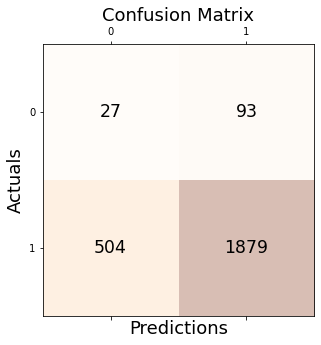

In [750]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [751]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_alibi_one))

Accuracy: 0.761
Precision: 0.953
Recall: 0.789
F1 Score: 0.863


## One SVM

### 1.

In [293]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [294]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [295]:
_df = np.array(_df).reshape(-1,2)

In [296]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [297]:
clf.fit(_df)

OneClassSVM(gamma=0.1, nu=0.1)

In [298]:
y_pred = clf.predict(_df)

In [299]:
outlier_OSVM_one = list(clf.predict(_df))

In [300]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_OSVM_one)

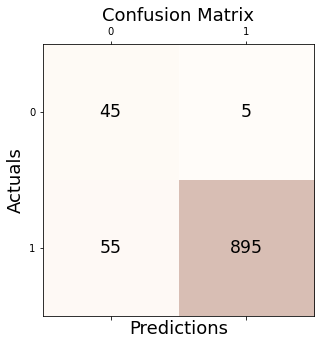

In [301]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [302]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_OSVM_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_OSVM_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_OSVM_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_OSVM_one))

Accuracy: 0.940
Precision: 0.994
Recall: 0.942
F1 Score: 0.968


### 2.

In [303]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [304]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [305]:
_df = np.array(_df).reshape(-1,2)

In [306]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [307]:
clf.fit(_df)

OneClassSVM(gamma=0.1, nu=0.1)

In [308]:
y_pred = clf.predict(_df)

In [309]:
outlier_OSVM_one = list(clf.predict(_df))

In [310]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_OSVM_one)

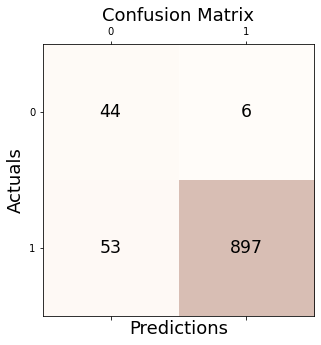

In [311]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [312]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_OSVM_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_OSVM_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_OSVM_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_OSVM_one))

Accuracy: 0.941
Precision: 0.993
Recall: 0.944
F1 Score: 0.968


### 3.

In [313]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [314]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [315]:
_df = np.array(_df).reshape(-1,2)

In [316]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [317]:
clf.fit(_df)

OneClassSVM(gamma=0.1, nu=0.1)

In [318]:
y_pred = clf.predict(_df)

In [319]:
outlier_OSVM_one = list(clf.predict(_df))

In [320]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_OSVM_one)

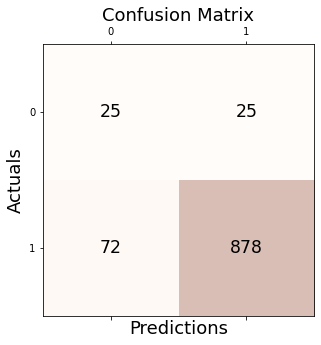

In [321]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [322]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_OSVM_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_OSVM_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_OSVM_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_OSVM_one))

Accuracy: 0.903
Precision: 0.972
Recall: 0.924
F1 Score: 0.948


### 4.

In [323]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [324]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [325]:
_df = np.array(_df).reshape(-1,2)

In [326]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [327]:
clf.fit(_df)

OneClassSVM(gamma=0.1, nu=0.1)

In [328]:
y_pred = clf.predict(_df)

In [329]:
outlier_OSVM_one = list(clf.predict(_df))

In [330]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_OSVM_one)

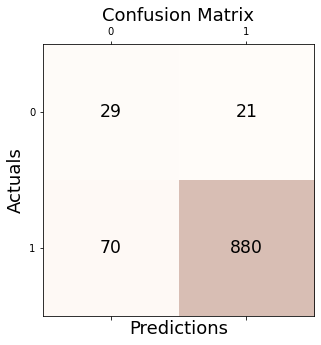

In [331]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [332]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_OSVM_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_OSVM_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_OSVM_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_OSVM_one))

Accuracy: 0.909
Precision: 0.977
Recall: 0.926
F1 Score: 0.951


### 5.

In [628]:
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + x

In [629]:
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})

In [630]:
_df = np.array(_df).reshape(-1,3)

In [631]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [632]:
clf.fit(_df)

OneClassSVM(gamma=0.1, nu=0.1)

In [633]:
y_pred = clf.predict(_df)

In [634]:
outlier_OSVM_one = list(clf.predict(_df))

In [635]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_OSVM_one)

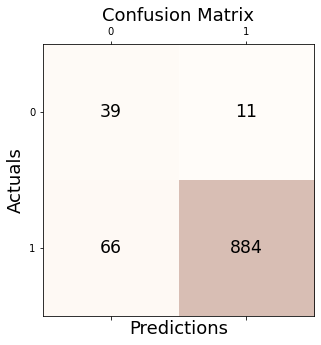

In [636]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [637]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_OSVM_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_OSVM_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_OSVM_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_OSVM_one))

Accuracy: 0.923
Precision: 0.988
Recall: 0.931
F1 Score: 0.958


### 6.

In [766]:
G = graphs.Bunny()
n = G.N

In [767]:
g = filters.Heat(G, tau=75) 

In [768]:
normal = np.random.randn(n)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif
index_of_trueoutlier2 = np.where(unif!=0)

In [769]:
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

2022-11-10 00:49:07,162:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.


In [770]:
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = -G.coords[:,2]

In [773]:
_df = pd.DataFrame({'x' : _x, 'y' : _y, 'z' : _z, 'fnoise':f+noise})

In [774]:
_df = np.array(_df).reshape(-1,4)

In [775]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [776]:
clf.fit(_df)

OneClassSVM(gamma=0.1, nu=0.1)

In [777]:
y_pred = clf.predict(_df)

In [778]:
outlier_OSVM_one = list(clf.predict(_df))

In [779]:
conf_matrix = confusion_matrix(outlier_true_one_2, outlier_OSVM_one)

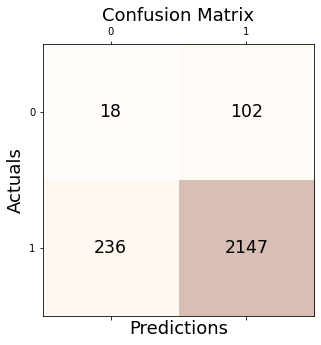

In [780]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [781]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one_2, outlier_OSVM_one))
print('Precision: %.3f' % precision_score(outlier_true_one_2, outlier_OSVM_one))
print('Recall: %.3f' % recall_score(outlier_true_one_2, outlier_OSVM_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one_2, outlier_OSVM_one))

Accuracy: 0.865
Precision: 0.955
Recall: 0.901
F1 Score: 0.927


## Circle

### 1. Simul, ABOD

In [1054]:
%%R
library(EbayesThresh)
set.seed(1)
n=5000
epsilon = rnorm(n)
signal = sample(c(runif(n*0.03,-7,-5), runif(n*0.02,6,7), rep(0,n*0.95)))
index_of_trueoutlier = which(signal!=0)
index_of_trueoutlier
x=signal+epsilon

In [1055]:
%R -o x
%R -o index_of_trueoutlier
%R -o signal

In [1071]:
n=5000

In [1056]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [1057]:
outlier_true_index = index_of_trueoutlier

In [1058]:
outlier_true_value = x[index_of_trueoutlier]

In [1059]:
outlier_true_one = signal.copy()

In [1060]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

In [1061]:
r=x+10
θ = np.linspace(-3.14,3.14,len(x))

In [1062]:
_x = r*np.cos(θ)
_y = r*np.sin(θ)

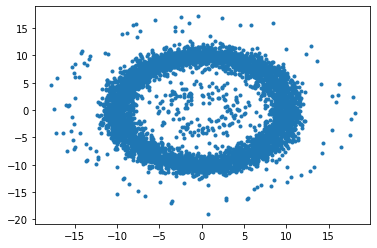

In [1063]:
plt.plot(_x,_y,'.')

In [1064]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [1065]:
abod_clf = ABOD(contamination=0.05)
abod_clf.fit(_df[['x', 'y']])

ABOD(contamination=0.05, method='fast', n_neighbors=5)

In [1066]:
_df['ABOD_Clf'] = abod_clf.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

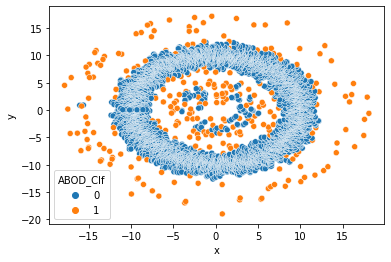

In [1067]:
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'ABOD_Clf')

In [1068]:
outlier_ABOD_one = list(abod_clf.labels_)

In [1069]:
outlier_ABOD_one = list(map(lambda x: 1 if x==0  else -1,outlier_ABOD_one))

In [1070]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        #self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [1072]:
w=np.zeros((n,n))

In [1073]:
for i in range(n):
    for j in range(n):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [1074]:
_simul = SIMUL(_df)

In [1075]:
_simul.fit(sd=20)

In [1076]:
outlier_simul_first_index = np.array(_simul.df.query('Residual**2>4').reset_index()['index'])

In [1077]:
outlier_simul_first_value = np.array(_simul.df.query('Residual**2>4').reset_index()['y'])

In [1078]:
outlier_simul_one = (_simul.df['Residual']**2).tolist()

In [1079]:
outlier_simul_one = list(map(lambda x: -1 if x > 4 else 1,outlier_simul_one))

In [1080]:
_simul.df=_simul.df.assign(one = outlier_simul_one)

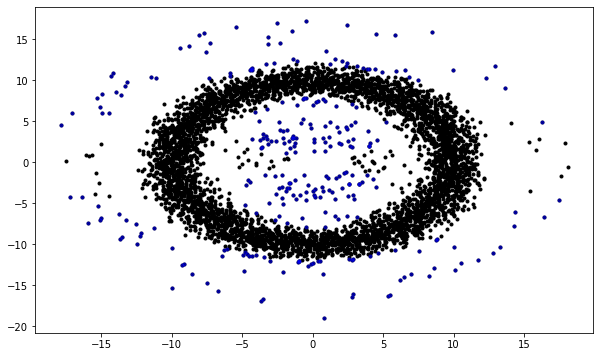

In [1081]:
plt.figure(figsize=(10,6))
plt.plot(_simul.df['x'],_simul.df['y'],'k.')
plt.plot(_simul.df.iloc[outlier_simul_first_index]['x'],_simul.df.iloc[outlier_simul_first_index]['y'],'b.',alpha=0.5)
# plt.xlim(-15,15)
# plt.ylim(-15,15)
# plt.plot(xhat,'go',alpha=0.3)

In [1082]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_simul_one)

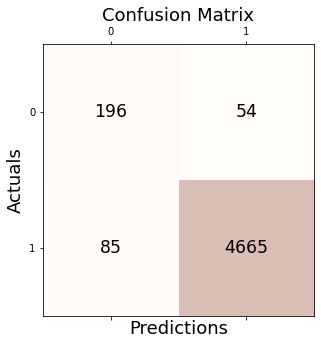

In [1083]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1084]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_simul_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_simul_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_simul_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_simul_one))

Accuracy: 0.972
Precision: 0.989
Recall: 0.982
F1 Score: 0.985


In [1085]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_ABOD_one)

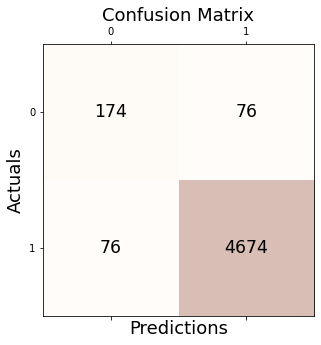

In [1086]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1087]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_ABOD_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_ABOD_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_ABOD_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_ABOD_one))

Accuracy: 0.970
Precision: 0.984
Recall: 0.984
F1 Score: 0.984


### 2. LOF

In [1098]:
X = np.array(_df)

In [1099]:
clf = LocalOutlierFactor(n_neighbors=2)

outlier

In [1100]:
outlier_first_index = np.where(clf.fit_predict(X)==-1)

In [1101]:
outlier_first_value = clf.fit_predict(X)[clf.fit_predict(X)==-1]

In [1102]:
conf_matrix = confusion_matrix(outlier_true_one, clf.fit_predict(X))

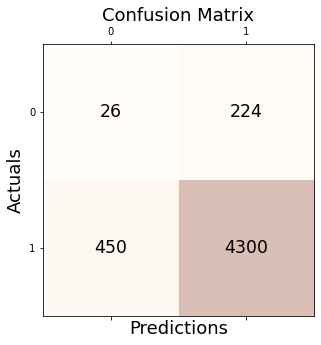

In [1103]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1104]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, clf.fit_predict(X)))
print('Precision: %.3f' % precision_score(outlier_true_one, clf.fit_predict(X)))
print('Recall: %.3f' % recall_score(outlier_true_one, clf.fit_predict(X)))
print('F1 Score: %.3f' % f1_score(outlier_true_one, clf.fit_predict(X)))

Accuracy: 0.865
Precision: 0.950
Recall: 0.905
F1 Score: 0.927


### 3. forest

In [1105]:
od = IForest(
    threshold=0.,
    n_estimators=100
)

In [1106]:
od.fit(_df[['x', 'y']])

In [1107]:
preds = od.predict(
    _df[['x', 'y']],
    return_instance_score=True
)

<AxesSubplot:xlabel='x', ylabel='y'>

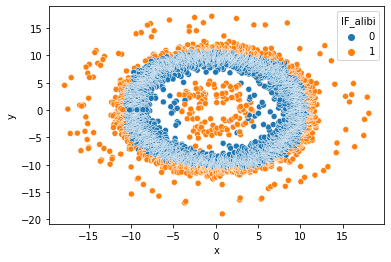

In [1108]:
_df['IF_alibi'] = preds['data']['is_outlier']
sns.scatterplot(data = _df, x = 'x', y = 'y', hue = 'IF_alibi')

In [1109]:
outlier_alibi_one = _df['IF_alibi']

In [1110]:
outlier_alibi_one = list(map(lambda x: 1 if x==0  else -1,outlier_alibi_one))

In [1111]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_alibi_one)

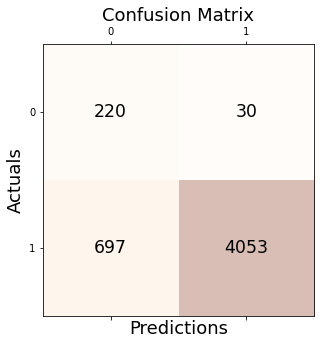

In [1112]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1113]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_alibi_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_alibi_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_alibi_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_alibi_one))

Accuracy: 0.855
Precision: 0.993
Recall: 0.853
F1 Score: 0.918


### 4. SVM

In [1114]:
_df=pd.DataFrame({'x':_x, 'y':_y})

In [1115]:
_df = np.array(_df).reshape(-1,2)

In [1116]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)

In [1117]:
clf.fit(_df)

OneClassSVM(gamma=0.1, nu=0.1)

In [1118]:
y_pred = clf.predict(_df)

In [1119]:
_df.shape

(5000, 2)

In [1120]:
outlier_OSVM_one = list(clf.predict(_df))

In [1121]:
conf_matrix = confusion_matrix(outlier_true_one, outlier_OSVM_one)

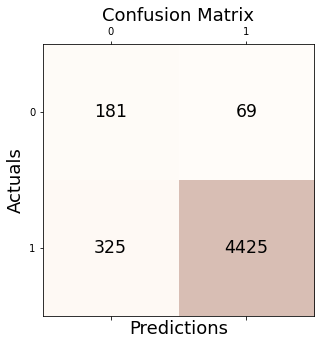

In [1122]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [1123]:
print('Accuracy: %.3f' % accuracy_score(outlier_true_one, outlier_OSVM_one))
print('Precision: %.3f' % precision_score(outlier_true_one, outlier_OSVM_one))
print('Recall: %.3f' % recall_score(outlier_true_one, outlier_OSVM_one))
print('F1 Score: %.3f' % f1_score(outlier_true_one, outlier_OSVM_one))

Accuracy: 0.921
Precision: 0.985
Recall: 0.932
F1 Score: 0.957
